# LinkNet + EfficientNet B3

In [ ]:
!pip install q tensorflow==2.1
!pip install q keras==2.3.1
!pip install segmentation_models
import segmentation_models as sm

# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
# !pip install -U albumentations==0.3.0 --user
!pip install -U albumentations==0.2.3 --user 

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
Requirement already up-to-date: albumentations==0.2.3 in /root/.local/lib/python3.7/site-packages (0.2.3)


In [ ]:
import os
# patchsize = 256

# Training data
x_train_dir = '/content/drive/MyDrive/Segmentation DS/384 DS Covid/Traintest/train/images'
y_train_dir = '/content/drive/MyDrive/Segmentation DS/384 DS Covid/Traintest/train/masks'

# Validation data
x_valid_dir = '/content/drive/MyDrive/Segmentation DS/384 DS Covid/Traintest/test/images'
y_valid_dir = '/content/drive/MyDrive/Segmentation DS/384 DS Covid/Traintest/test/masks'


x_test_dir = '/content/drive/MyDrive/Segmentation DS/384 DS Covid/Traintest/testt/images'
y_test_dir = '/content/drive/MyDrive/Segmentation DS/384 DS Covid/Traintest/testt/masks'

print("Training and validation and test samples: ", len(os.listdir(x_train_dir)), len(os.listdir(x_valid_dir)), len(os.listdir(x_test_dir)))

Training and validation and test samples:  500 300 20


In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['target1' , 'background']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()



#####################################################
    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        # newer version of tf/keras want batch to be in tuple rather than list
        return tuple(batch)
#########################################################




    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

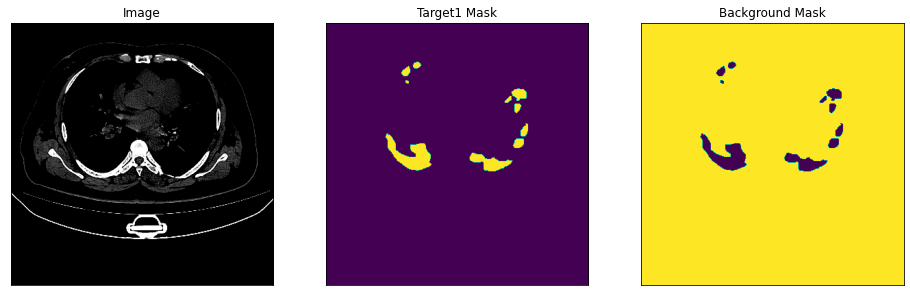

In [ ]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['target1' , 'background'])

image, mask = dataset[50] # get some sample
visualize(
    image=image, 
    # cars_mask=mask[..., 0].squeeze(),
    target1_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 0].squeeze(),
)

In [ ]:
import albumentations as A

In [ ]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=384, min_width=384, always_apply=True, border_mode=0),
        A.RandomCrop(height=384, width=384, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        # A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 384)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        # A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

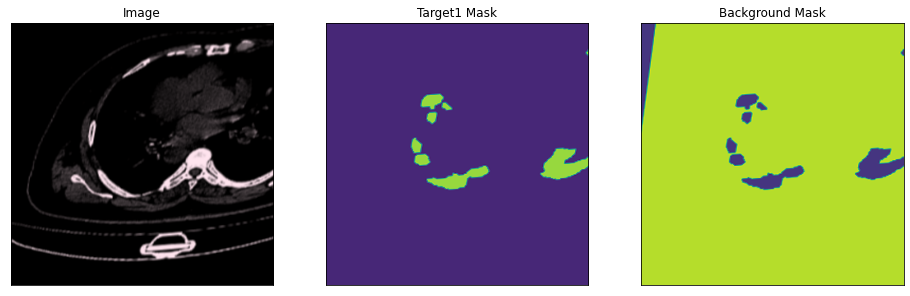

In [ ]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['target1', 'background'], augmentation=get_training_augmentation())

image, mask = dataset[50] # get some sample
visualize(
    image=image, 
    # cars_mask=mask[..., 0].squeeze(),
    target1_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 0].squeeze(),
)

In [ ]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

In [ ]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['target1']
LR = 0.0001
EPOCHS = 20

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Linknet(BACKBONE, classes=n_classes, activation=activation)



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (512, 512, 3)
# I personally would chose (None, None, 3) for the input shape
#

In [ ]:
model.summary()

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('./LinkNet-EfficientNetB3.csv', separator=",", append=True)
]

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/20
62/62 [==============================] - 374s 6s/step - loss: 0.3102 - iou_score: 0.7283 - f1-score: 0.8409 - val_loss: 0.1992 - val_iou_score: 0.9100 - val_f1-score: 0.9527
Epoch 2/20
62/62 [==============================] - 66s 1s/step - loss: 0.2120 - iou_score: 0.8738 - f1-score: 0.9322 - val_loss: 0.2006 - val_iou_score: 0.8780 - val_f1-score: 0.9342
Epoch 3/20
62/62 [==============================] - 65s 1s/step - loss: 0.1528 - iou_score: 0.9313 - f1-score: 0.9643 - val_loss: 0.2162 - val_iou_score: 0.8032 - val_f1-score: 0.8898
Epoch 4/20
62/62 [==============================] - 65s 1s/step - loss: 0.1285 - iou_score: 0.9394 - f1-score: 0.9687 - val_loss: 0.1839 - val_iou_score: 0.8347 - val_f1-score: 0.9090
Epoch 5/20
62/62 [==============================] - 66s 1s/step - loss: 0.1124 - iou_score: 0.9457 - f1-score: 0.9720 - val_loss: 0.1195 - val_iou_score: 0.9370 - val_f1-score: 0.9673
Epoch 6/20
62/62 [==============================] - 65s 1s/step - loss: 0.0977 

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.024351
mean iou_score: 0.97291
mean f1-score: 0.98624


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.089618
mean iou_score: 0.92471
mean f1-score: 0.96069


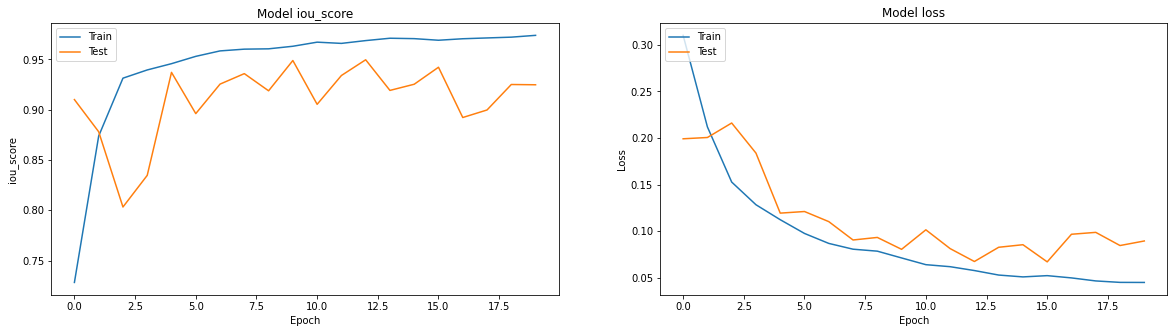

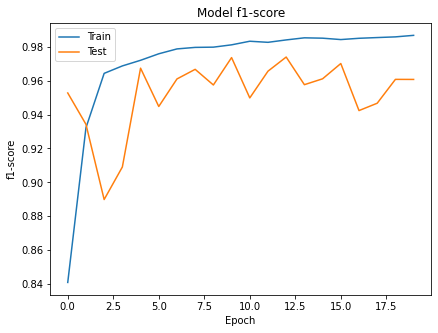

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# Plot training & validation f1_score values
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

In [ ]:
# load best weights
model.load_weights('best_model.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.11713
mean iou_score: 0.92104
mean f1-score: 0.95881


# Linknet + Mobilenet V2

In [ ]:
import segmentation_models as sm

In [ ]:
BACKBONE = 'mobilenetv2'
BATCH_SIZE = 8
CLASSES = ['target1']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Linknet(BACKBONE, classes=n_classes, activation=activation)
# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (None, None, 3))

/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [ ]:
model.summary()

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 384, 384, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 384, 384, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('./Linknet-MobilenetV2.csv', separator=",", append=True)
]

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
62/62 [==============================] - 68s 1s/step - loss: 0.3502 - iou_score: 0.6358 - f1-score: 0.7698 - val_loss: 0.3361 - val_iou_score: 0.5465 - val_f1-score: 0.7058
Epoch 2/10
62/62 [==============================] - 44s 717ms/step - loss: 0.2328 - iou_score: 0.8625 - f1-score: 0.9255 - val_loss: 0.1901 - val_iou_score: 0.9024 - val_f1-score: 0.9485
Epoch 3/10
62/62 [==============================] - 44s 715ms/step - loss: 0.1735 - iou_score: 0.9099 - f1-score: 0.9526 - val_loss: 0.1399 - val_iou_score: 0.9567 - val_f1-score: 0.9777
Epoch 4/10
62/62 [==============================] - 44s 716ms/step - loss: 0.1424 - iou_score: 0.9290 - f1-score: 0.9630 - val_loss: 0.1056 - val_iou_score: 0.9667 - val_f1-score: 0.9829
Epoch 5/10
62/62 [==============================] - 45s 721ms/step - loss: 0.1250 - iou_score: 0.9342 - f1-score: 0.9658 - val_loss: 0.0854 - val_iou_score: 0.9761 - val_f1-score: 0.9878
Epoch 6/10
62/62 [==============================] - 44s 707ms/step -

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.11771
mean iou_score: 0.9136
mean f1-score: 0.95451


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.053166
mean iou_score: 0.96972
mean f1-score: 0.9844


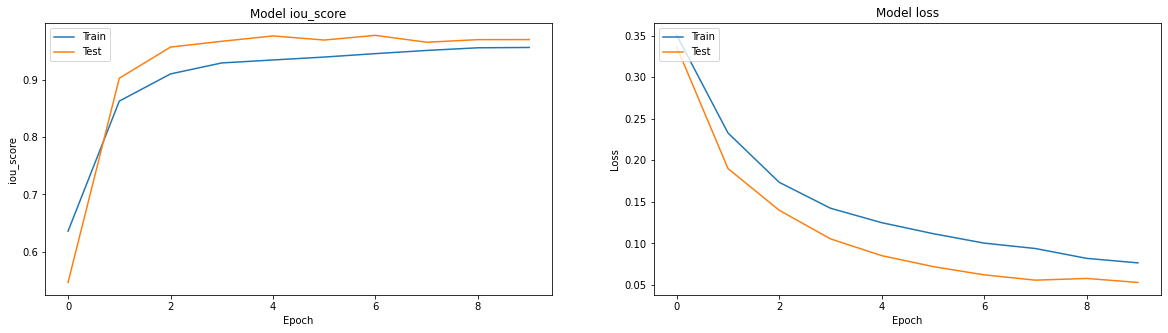

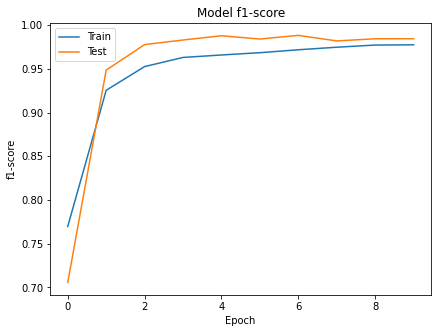

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# Plot training & validation f1_score values
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

In [ ]:
# load best weights
model.load_weights('best_model.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.081569
mean iou_score: 0.96189
mean f1-score: 0.98044


# Linknet + Inception resnet V2

In [ ]:
import segmentation_models as sm

In [ ]:
BACKBONE = 'inceptionresnetv2'
BATCH_SIZE = 8
CLASSES = ['target1']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Linknet(BACKBONE, classes=n_classes, activation=activation)
# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (None, None, 3))

In [ ]:
model.summary()

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 384, 384, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 384, 384, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('./Linknet-inceptionresnetv2V2.csv', separator=",", append=True)
]

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
62/62 [==============================] - 168s 3s/step - loss: 0.2979 - iou_score: 0.7879 - f1-score: 0.8797 - val_loss: 0.1423 - val_iou_score: 0.9772 - val_f1-score: 0.9883
Epoch 2/10
62/62 [==============================] - 86s 1s/step - loss: 0.2271 - iou_score: 0.8805 - f1-score: 0.9359 - val_loss: 0.1047 - val_iou_score: 0.9561 - val_f1-score: 0.9772
Epoch 3/10
62/62 [==============================] - 86s 1s/step - loss: 0.1677 - iou_score: 0.9268 - f1-score: 0.9618 - val_loss: 0.1050 - val_iou_score: 0.9087 - val_f1-score: 0.9514
Epoch 4/10
62/62 [==============================] - 86s 1s/step - loss: 0.1355 - iou_score: 0.9432 - f1-score: 0.9707 - val_loss: 0.1173 - val_iou_score: 0.8489 - val_f1-score: 0.9172
Epoch 5/10
62/62 [==============================] - 86s 1s/step - loss: 0.1154 - iou_score: 0.9475 - f1-score: 0.9730 - val_loss: 0.1061 - val_iou_score: 0.8650 - val_f1-score: 0.9257
Epoch 6/10
62/62 [==============================] - 86s 1s/step - loss: 0.0972 

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.078064
mean iou_score: 0.96151
mean f1-score: 0.98032


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.064585
mean iou_score: 0.93352
mean f1-score: 0.96459


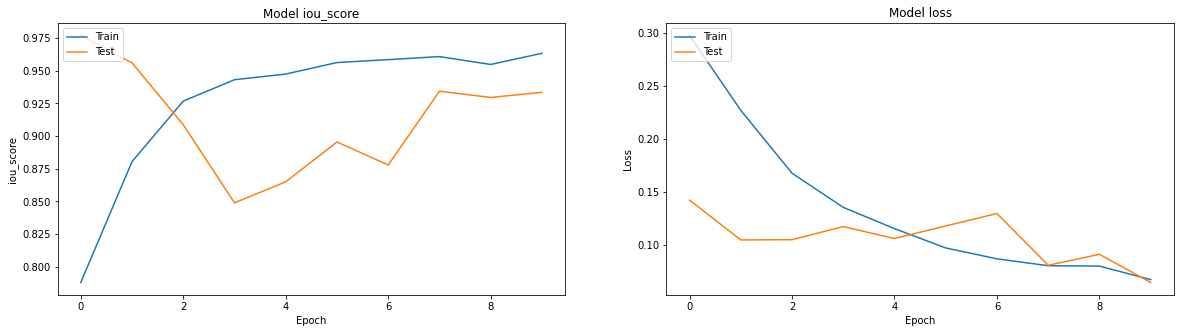

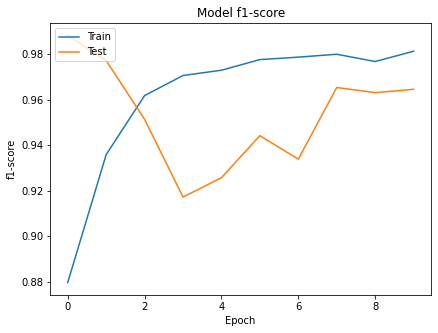

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# Plot training & validation f1_score values
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

In [ ]:
# load best weights
model.load_weights('best_model.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.082322
mean iou_score: 0.96145
mean f1-score: 0.98023


# Linknet + DenseNet 121

In [ ]:
import segmentation_models as sm

In [ ]:
BACKBONE = 'densenet121'
BATCH_SIZE = 8
CLASSES = ['target1']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Linknet(BACKBONE, classes=n_classes, activation=activation)
# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (None, None, 3))

29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 384, 384, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 384, 384, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('./Linknet-densenet121.csv', separator=",", append=True)
]

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
62/62 [==============================] - 122s 2s/step - loss: 0.3431 - iou_score: 0.7112 - f1-score: 0.8255 - val_loss: 0.2625 - val_iou_score: 0.9031 - val_f1-score: 0.9489
Epoch 2/10
62/62 [==============================] - 64s 1s/step - loss: 0.2321 - iou_score: 0.8882 - f1-score: 0.9405 - val_loss: 0.1901 - val_iou_score: 0.9304 - val_f1-score: 0.9635
Epoch 3/10
62/62 [==============================] - 64s 1s/step - loss: 0.1805 - iou_score: 0.9141 - f1-score: 0.9549 - val_loss: 0.1451 - val_iou_score: 0.9431 - val_f1-score: 0.9704
Epoch 4/10
62/62 [==============================] - 64s 1s/step - loss: 0.1485 - iou_score: 0.9294 - f1-score: 0.9633 - val_loss: 0.1180 - val_iou_score: 0.9258 - val_f1-score: 0.9606
Epoch 5/10
62/62 [==============================] - 64s 1s/step - loss: 0.1265 - iou_score: 0.9420 - f1-score: 0.9700 - val_loss: 0.1188 - val_iou_score: 0.9034 - val_f1-score: 0.9483
Epoch 6/10
62/62 [==============================] - 64s 1s/step - loss: 0.1086 

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.055173
mean iou_score: 0.96715
mean f1-score: 0.98327


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.065128
mean iou_score: 0.9509
mean f1-score: 0.97429


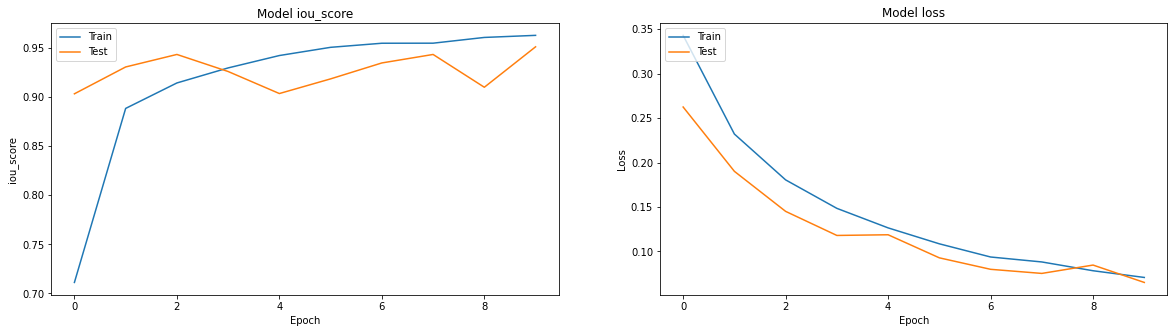

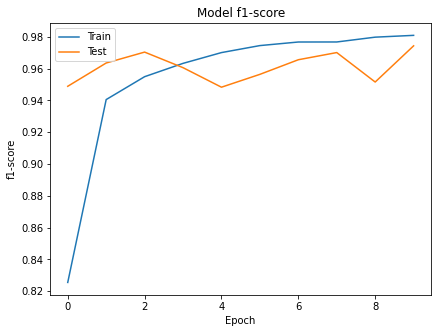

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# Plot training & validation f1_score values
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

In [ ]:
# load best weights
# model.load_weights('best_model.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.11934
mean iou_score: 0.9157
mean f1-score: 0.95588


# Linknet + SeresNext 101

In [ ]:
import segmentation_models as sm

In [ ]:
BACKBONE = 'seresnext101'
BATCH_SIZE = 8
CLASSES = ['target1']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Linknet(BACKBONE, classes=n_classes, activation=activation)
# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (None, None, 3))

In [ ]:
model.summary()

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 384, 384, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 384, 384, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('./Linknet-seresnext101.csv', separator=",", append=True)
]

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
62/62 [==============================] - 341s 5s/step - loss: 0.2530 - iou_score: 0.8564 - f1-score: 0.9211 - val_loss: 0.2787 - val_iou_score: 0.7578 - val_f1-score: 0.8617
Epoch 2/10
62/62 [==============================] - 145s 2s/step - loss: 0.1741 - iou_score: 0.9193 - f1-score: 0.9577 - val_loss: 0.2736 - val_iou_score: 0.8389 - val_f1-score: 0.9120
Epoch 3/10
62/62 [==============================] - 143s 2s/step - loss: 0.1327 - iou_score: 0.9435 - f1-score: 0.9709 - val_loss: 0.1579 - val_iou_score: 0.9449 - val_f1-score: 0.9714
Epoch 4/10
62/62 [==============================] - 143s 2s/step - loss: 0.1059 - iou_score: 0.9545 - f1-score: 0.9767 - val_loss: 0.0992 - val_iou_score: 0.9543 - val_f1-score: 0.9760
Epoch 5/10
62/62 [==============================] - 144s 2s/step - loss: 0.0982 - iou_score: 0.9548 - f1-score: 0.9768 - val_loss: 0.0798 - val_iou_score: 0.9741 - val_f1-score: 0.9868
Epoch 6/10
62/62 [==============================] - 143s 2s/step - loss: 0.

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.0392
mean iou_score: 0.96586
mean f1-score: 0.9826


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.06564
mean iou_score: 0.93737
mean f1-score: 0.96719


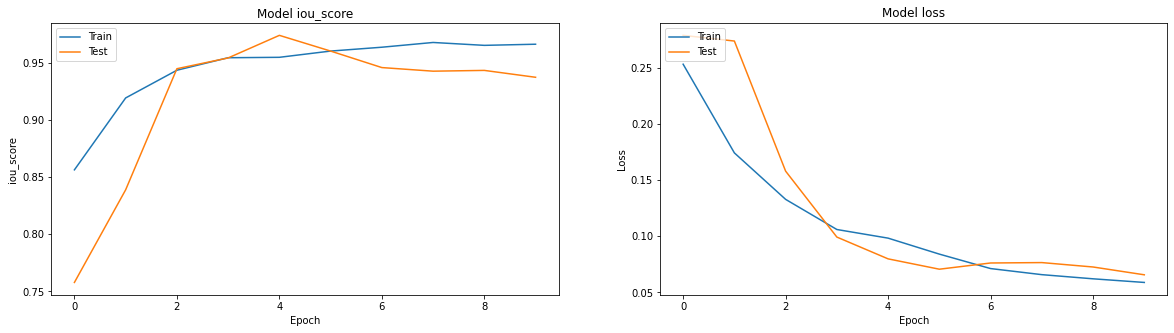

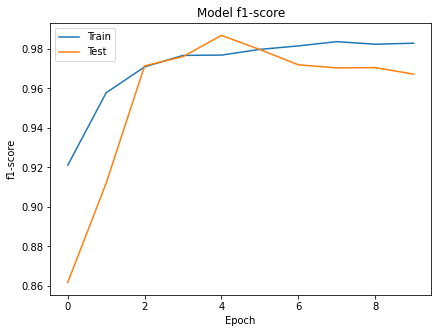

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# Plot training & validation f1_score values
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

In [ ]:
# load best weights
model.load_weights('best_model.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.098967
mean iou_score: 0.94912
mean f1-score: 0.97379


# Linknet + VGG19

In [ ]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

In [ ]:
BACKBONE = 'vgg19'
BATCH_SIZE = 8
CLASSES = ['target1']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Linknet(BACKBONE, classes=n_classes, activation=activation)



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (512, 512, 3)
# I personally would chose (None, None, 3) for the input shape
#

In [ ]:
# model.summary()

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 384, 384, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 384, 384, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('./LinkNet-Vgg19.csv', separator=",", append=True)
]

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
220/220 [==============================] - 1226s 6s/step - loss: 0.1895 - iou_score: 0.8911 - f1-score: 0.9410 - val_loss: 0.0871 - val_iou_score: 0.9731 - val_f1-score: 0.9863
Epoch 2/10
220/220 [==============================] - 263s 1s/step - loss: 0.0966 - iou_score: 0.9502 - f1-score: 0.9743 - val_loss: 0.0714 - val_iou_score: 0.9477 - val_f1-score: 0.9728
Epoch 3/10
220/220 [==============================] - 263s 1s/step - loss: 0.0732 - iou_score: 0.9569 - f1-score: 0.9779 - val_loss: 0.0828 - val_iou_score: 0.9331 - val_f1-score: 0.9650
Epoch 4/10
220/220 [==============================] - 263s 1s/step - loss: 0.0574 - iou_score: 0.9645 - f1-score: 0.9819 - val_loss: 0.0619 - val_iou_score: 0.9513 - val_f1-score: 0.9747
Epoch 5/10
220/220 [==============================] - 262s 1s/step - loss: 0.0476 - iou_score: 0.9680 - f1-score: 0.9837 - val_loss: 0.0589 - val_iou_score: 0.9546 - val_f1-score: 0.9766
Epoch 6/10
220/220 [==============================] - 263s 1s/st

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.013172
mean iou_score: 0.97797
mean f1-score: 0.98883


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.04778
mean iou_score: 0.96768
mean f1-score: 0.98342


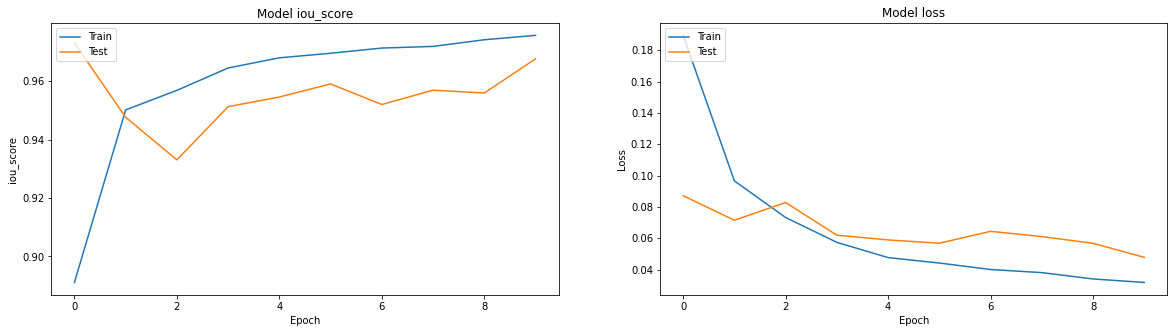

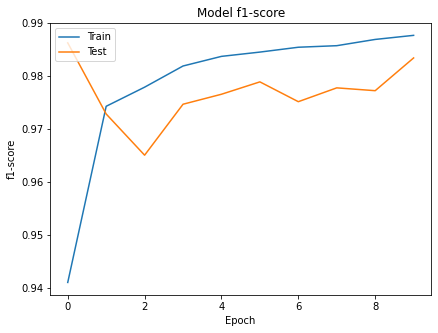

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# Plot training & validation f1_score values
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

In [ ]:
# load best weights
# model.load_weights('best_model.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.085853
mean iou_score: 0.95749
mean f1-score: 0.97749
